In [32]:
import PyPDF2 
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import json
import os
from IPython.display import display, Markdown

C:\Users\Sneha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [33]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [34]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return text

In [35]:
def preprocess(text):
    text = re.sub(r'\s+', ' ', text)
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_sentences = []
    for sent in sentences:
        if len(sent.strip()) < 5:
            continue
        words = word_tokenize(sent)
        filtered = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
        if filtered:
            clean_sentences.append((sent, ' '.join(filtered)))
    return clean_sentences

In [36]:
def get_resume_categories():
    categories = {
        'Name': ['name', 'profile', 'personal', 'bio', 'candidate'],
        'Contact Information': ['contact', 'email', 'phone', 'linkedin', 'github', 'address', 'mobile', 'tel', 'website'],
        'Work Experience': ['experience', 'work', 'employment', 'job', 'position', 'role', 'company', 'organization', 
                           'history', 'professional', 'career', 'intern', 'internship'],
        'Education': ['education', 'university', 'college', 'school', 'degree', 'academic', 'graduation', 'bachelor', 
                     'master', 'phd', 'gpa', 'cgpa', 'grade', 'qualification'],
        'Projects': ['project', 'application', 'developed', 'built', 'created', 'implemented', 'designed', 'system',
                    'development', 'portfolio', 'github'],
        'Skills & Tools': ['skills', 'technologies', 'tools', 'languages', 'proficient', 'expertise', 'programming',
                          'technical', 'framework', 'library', 'platform', 'software', 'hardware', 'competencies'],
        'Achievements': ['award', 'prize', 'achievement', 'honor', 'recognition', 'scholarship', 'won', 'received',
                        'accomplishment', 'certified', 'winner'],
        'Certifications': ['certification', 'course', 'certified', 'license', 'completed', 'training', 'credential', 
                          'diploma', 'certificate', 'program'],
        'Interests': ['interest', 'hobby', 'hobbies', 'activity', 'passion', 'volunteer', 'volunteering', 'extracurricular']
    }
    
    return categories

In [37]:
class ResumeParser:
    def __init__(self):
        self.categories = get_resume_categories()
        self.category_docs = {category: ' '.join(keywords) for category, keywords in self.categories.items()}
    def parse(self, resume_text):
        self.clean_sentences = preprocess(resume_text)
        print(f"Extracted {len(self.clean_sentences)} sentences from the resume")
        self.categorized_sentences = self.hybrid_categorization()
        structured_data = self.format_resume_output()
        return structured_data, self.categorized_sentences
    
    def hybrid_categorization(self):
        tfidf_vectorizer = TfidfVectorizer()
        sentence_docs = [sent[1] for sent in self.clean_sentences]
        category_docs_list = list(self.category_docs.values())
        all_docs = category_docs_list + sentence_docs
        tfidf_matrix = tfidf_vectorizer.fit_transform(all_docs)
        category_vectors = tfidf_matrix[:len(category_docs_list)]
        sentence_vectors = tfidf_matrix[len(category_docs_list):]
        similarities = cosine_similarity(sentence_vectors, category_vectors)
        category_names = list(self.categories.keys())
        category_weights = {
            'Name': 1.2,
            'Contact Information': 1.5,
            'Education': 1.0,
            'Work Experience': 0.9,
            'Projects': 0.8,
            'Skills & Tools': 1.1,
            'Achievements': 1.3,
            'Certifications': 1.4,
            'Interests': 0.7
        }
        for i, category in enumerate(category_names):
            similarities[:, i] *= category_weights[category]
        categorized = {category: [] for category in category_names}
        for i, similarity_scores in enumerate(similarities):
            best_category_idx = np.argmax(similarity_scores)
            if similarity_scores[best_category_idx] > 0.02: 
                categorized[category_names[best_category_idx]].append(self.clean_sentences[i][0])
        
        return categorized
    
    def extract_name(self, text):
        first_lines = text.strip().split('\n')[:3] 
        for line in first_lines:
            line = line.strip()
            if len(line) > 0:
                if line.isupper() and len(line) > 3 and len(line.split()) <= 4:
                    return line
                if all(part[0].isupper() for part in line.split() if part) and len(line.split()) <= 4:
                    return line
        if self.categorized_sentences['Name']:
            return self.categorized_sentences['Name'][0].strip()
        return "Name not found"
    
    def extract_contact_info(self, text):
        contact_info = {}
        email_match = re.search(r'[\w\.-]+@[\w\.-]+\.\w+', text)
        if email_match:
            contact_info['Email'] = email_match.group(0)
        phone_match = re.search(r'(?:\+\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}|\+\d{1,3}\s\d{10}|\+\d{10,}', text)
        if phone_match:
            contact_info['Phone'] = phone_match.group(0)
        linkedin_match = re.search(r'linkedin\.com/(?:in/|profile/)?([\w-]+)', text)
        if linkedin_match:
            contact_info['LinkedIn'] = f"linkedin.com/in/{linkedin_match.group(1)}"
        github_match = re.search(r'github\.com/([\w-]+)', text)
        if github_match:
            contact_info['GitHub'] = f"github.com/{github_match.group(1)}"
        website_matches = re.findall(r'https?://(?:www\.)?([\w.-]+\.[a-zA-Z]{2,})[^\s,]*', text)
        websites = []
        for match in website_matches:
            if 'linkedin' not in match and 'github' not in match:
                websites.append(match)
        if websites:
            contact_info['Websites'] = websites
        location_match = re.search(r'([A-Z][a-z]+(?:\s[A-Z][a-z]+)*),\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)', text)
        if location_match:
            contact_info['Location'] = location_match.group(0)
        return contact_info
    
    def format_resume_output(self):
        all_text = ' '.join([sent for category in self.categorized_sentences.values() for sent in category])
        original_text = ' '.join([sent[0] for sent in self.clean_sentences])
        output = {}
        output['Name'] = self.extract_name(original_text)
        output['Contact'] = self.extract_contact_info(original_text)
        for category in ['Education', 'Work Experience', 'Projects', 'Skills & Tools', 'Achievements', 'Certifications', 'Interests']:
            if category in self.categorized_sentences and self.categorized_sentences[category]:
                cleaned_items = []
                for item in self.categorized_sentences[category]:
                    cleaned = re.sub(r'\s+', ' ', item.strip())
                    if cleaned and len(cleaned) > 3:  # Skip very short items
                        cleaned_items.append(cleaned)
                output[category] = cleaned_items
        
        return output


In [38]:
def print_parsed_resume(structured_data):
    print("\n===== PARSED RESUME INFORMATION =====\n")
    print(f"NAME: {structured_data.get('Name', 'Not found')}")
    print("\nCONTACT INFORMATION:")
    contact = structured_data.get('Contact', {})
    if contact:
        for key, value in contact.items():
            print(f"- {key}: {value}")
    else:
        print("- No contact information found")
    category_order = [
        'Education',
        'Work Experience',
        'Projects',
        'Skills & Tools',
        'Achievements', 
        'Certifications',
        'Interests'
    ]
    
    for category in category_order:
        if category in structured_data and structured_data[category]:
            print(f"\n{category.upper()}:")
            for i, item in enumerate(structured_data[category], 1):
                print(f"{i}. {item}")
    
    print("\n=====================================")
    markdown_text = f"# {structured_data.get('Name', 'Resume')}\n\n"
    markdown_text += "## Contact Information\n"
    if contact:
        for key, value in contact.items():
            if isinstance(value, list):
                markdown_text += f"- **{key}**: {', '.join(value)}\n"
            else:
                markdown_text += f"- **{key}**: {value}\n"
    else:
        markdown_text += "- No contact information found\n"
    for category in category_order:
        if category in structured_data and structured_data[category]:
            markdown_text += f"\n## {category}\n"
            for item in structured_data[category]:
                markdown_text += f"- {item}\n"
    
    return display(Markdown(markdown_text))


In [39]:
def save_results(structured_data, categorized_data, output_path="resume_parsed.json"):
    results = {
        "structured_data": structured_data,
        "categorized_data": categorized_data
    }
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"Results saved to {output_path}")



In [40]:

def evaluate_categorization(categorized_data):
    total_sentences = sum(len(sentences) for sentences in categorized_data.values())
    distribution = {category: len(sentences)/max(1, total_sentences) 
                   for category, sentences in categorized_data.items()}
    empty_categories = [category for category, sentences in categorized_data.items() 
                        if not sentences]
    print("Category distribution:")
    for category, percentage in distribution.items():
        print(f"{category}: {percentage:.2%} ({len(categorized_data[category])} sentences)")
    print(f"\nEmpty categories: {empty_categories if empty_categories else 'None'}")
    balance_score = 1 - np.std(list(distribution.values()))
    print(f"\nBalance score (higher is better): {balance_score:.4f}")
    df = pd.DataFrame(list(distribution.items()), columns=['Category', 'Percentage'])
    return df

In [49]:
def parse_resume(file_path):
    """Main function to parse a resume file"""
    # Extract text from the resume file
    resume_text = extract_text_from_pdf(file_path)
    if not resume_text:
        print(f"Failed to extract text from {file_path}")
        return None, None
    
    print(f"Extracted {len(resume_text)} characters from the resume")
    parser = ResumeParser()
    structured_data, categorized_data = parser.parse(resume_text)
    
    print_parsed_resume(structured_data)
    df = evaluate_categorization(categorized_data)
    filename = os.path.basename(file_path)
    base_name = os.path.splitext(filename)[0]
    save_results(structured_data, categorized_data, f"{base_name}_parsed.json")
    return structured_data, categorized_data, df

In [50]:

resume_file_path = "sneha_resume.pdf"



In [51]:
# Parse the resume
structured_data, categorized_data, distribution_df = parse_resume(resume_file_path)


Extracted 3406 characters from the resume
Extracted 15 sentences from the resume

===== PARSED RESUME INFORMATION =====

NAME: Name not found

CONTACT INFORMATION:
- Email: snehakumari64445@gmail.com
- Phone: +91 9310913758
- LinkedIn: linkedin.com/in/sneha422
- Websites: ['sneha.everydayseries.io']
- Location: Faridabad, India

EDUCATION:
1. SNEHA KUMARI Faridabad, India +91 9310913758 snehakumari64445@gmail.com linkedin.com/in/sneha422 https://sneha.everydayseries.io/ Education Manav Rachna University 2022 – 2026 Bachelor of Technology in Computer Science and Technology (maintain ing SGPA of 8.82 ) Faridabad, India Tagore Academy Public School, Sec 3, FBD 2022 CBSE 12th (85%) 10th (92.6%) Experience Remote Advanced Nonlinear Technologies Limited (London, U K) 13 Jan’25 – Present Software Developer (Gen AI) Intern (10,000/month) - Engaged in a 12 -week career readiness program focused on Generative AI applications in professional and technical domains.
2. Achievements - Holding reputa

# Name not found

## Contact Information
- **Email**: snehakumari64445@gmail.com
- **Phone**: +91 9310913758
- **LinkedIn**: linkedin.com/in/sneha422
- **Websites**: sneha.everydayseries.io
- **Location**: Faridabad, India

## Education
- SNEHA KUMARI Faridabad, India +91 9310913758 snehakumari64445@gmail.com linkedin.com/in/sneha422 https://sneha.everydayseries.io/ Education Manav Rachna University 2022 – 2026 Bachelor of Technology in Computer Science and Technology (maintain ing SGPA of 8.82 ) Faridabad, India Tagore Academy Public School, Sec 3, FBD 2022 CBSE 12th (85%) 10th (92.6%) Experience Remote Advanced Nonlinear Technologies Limited (London, U K) 13 Jan’25 – Present Software Developer (Gen AI) Intern (10,000/month) - Engaged in a 12 -week career readiness program focused on Generative AI applications in professional and technical domains.
- Achievements - Holding reputation among Top 10% in Quine and won $1 92 dollars - Participated in Amity University's hackathon, achieving a top 10 rank out of 97 participating teams.

## Projects
- - Currently working on a capstone project to design, develop, and present a comprehensive Generative AI solution .
- INeuron AI 16 June ’24 – 22 july’24 Project Intern (Unpaid) - Developed an AI system that provides fashion advice and generates custom outfit images based on user prompts.
- Projects YouTube Comment Analyzer | React , Python | Try out | Blog - Developed a Flask -based API using Google Cloud Console and YouTube Data API v3 to extract all YouTube comments beyond the 100 -limit using regex -based ID extraction and pagination handling.
- Once installed, the extension analyzes the project's package, identifies the main file, and reviews the entire source code.
- - To use it enter either the Gemini API or MindsDB API, it will then generates a structured and informative README based on the project's setup and dependencies .

## Skills & Tools
- Profile Links • GitHub • Leet Code (Contest Rating: 1,573 | Top: 26.83% ) • Code 360 • Portfolio Technical Skills Languages : C, C++, Python , HTML/CSS, JavaScript , Java Technologies/Frameworks/Libraries : React JS, React Native, Git , GitHu b, MindsDB

## Achievements
- - 1st Prize Winner in the Health Tech Innovation Fest at MRIIRS.


Category distribution:
Name: 0.00% (0 sentences)
Contact Information: 0.00% (0 sentences)
Work Experience: 0.00% (0 sentences)
Education: 22.22% (2 sentences)
Projects: 55.56% (5 sentences)
Skills & Tools: 11.11% (1 sentences)
Achievements: 11.11% (1 sentences)
Certifications: 0.00% (0 sentences)
Interests: 0.00% (0 sentences)

Empty categories: ['Name', 'Contact Information', 'Work Experience', 'Certifications', 'Interests']

Balance score (higher is better): 0.8263
Results saved to sneha_resume_parsed.json


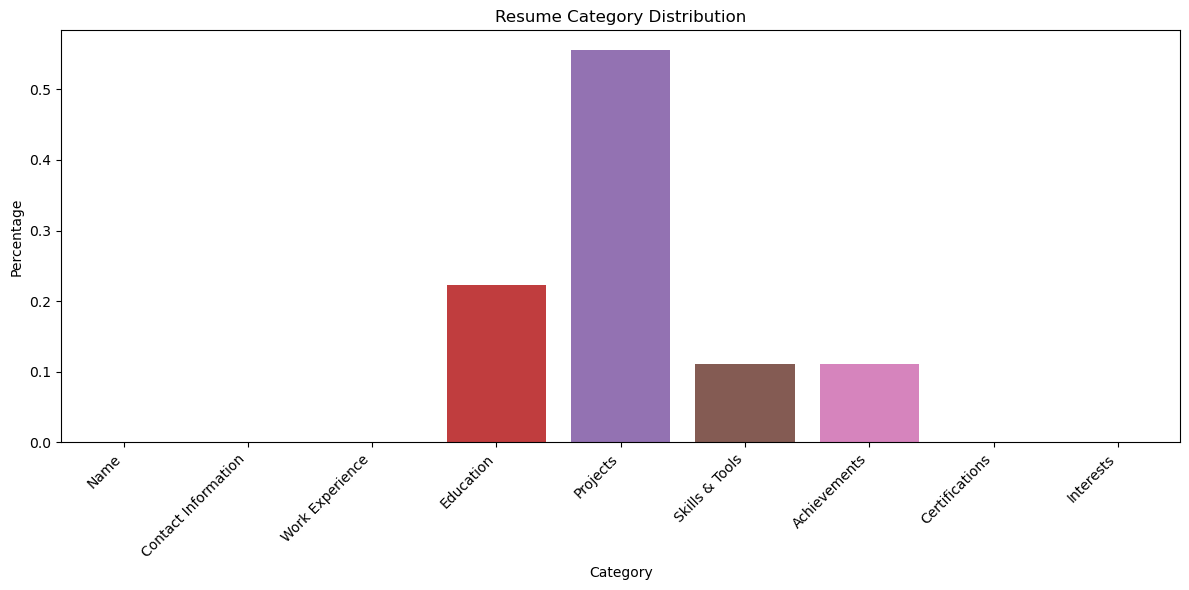

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Category', y='Percentage', data=distribution_df)
plt.title('Resume Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()